# Salary prediction by vacancy name, key skills, experience and description based on Word2Vec model

In [174]:
import pandas as pd

import re

from gensim.models import Word2Vec

# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from pymorphy2 import MorphAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LinearRegression

from tqdm import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [54]:
RANDOM_STATE = 42

## 1. Data overview

In [39]:
df = pd.read_csv('vacancies.csv')

In [4]:
df.head()

,name,experience,schedule,employment,description,key_skills,salary
0,Водитель-экспедитор,От 3 до 6 лет,Полный день,Полная занятость,"Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ ...",[],42500.0
1,Кладовщик-комплектовщик/оператор 1С,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности: Списывание материалов в произво...,"['знание пк', 'работа в 1С', 'Работа в команде...",50000.0
2,"Продавец магазина ""Магнит"" (Кировский р-он, В....",Нет опыта,Сменный график,Полная занятость,"В крупнейшую Федеральную сеть магазинов ""Магни...",[],31500.0
3,Администратор магазина (ТЦ Spar),От 1 года до 3 лет,Полный день,Полная занятость,Крупная федеральная сеть магазинов мужской и ж...,[],36700.0
4,Мойщик посуды (кулинария),Нет опыта,Сменный график,Полная занятость,Обязанности: Уборка производственных площадей...,"['Пользователь ПК', 'Грамотная речь', 'Работа ...",37000.0


In [6]:
df.shape

(16629, 7)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16629 entries, 0 to 16628
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         16629 non-null  object 
 1   experience   16629 non-null  object 
 2   schedule     16629 non-null  object 
 3   employment   16629 non-null  object 
 4   description  16629 non-null  object 
 5   key_skills   16629 non-null  object 
 6   salary       16629 non-null  float64
dtypes: float64(1), object(6)
memory usage: 909.5+ KB


## 2. Data preprocessing

### 2.1. Choose full-day and full-time vacancies only and check salary distrubition

In [43]:
df = df.loc[(df['schedule']=='Полный день') & (df['employment']=='Полная занятость')]

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11090 entries, 0 to 16628
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         11090 non-null  object 
 1   experience   11090 non-null  object 
 2   schedule     11090 non-null  object 
 3   employment   11090 non-null  object 
 4   description  11090 non-null  object 
 5   key_skills   11090 non-null  object 
 6   salary       11090 non-null  float64
dtypes: float64(1), object(6)
memory usage: 693.1+ KB


In [45]:
df = df.drop(['schedule', 'employment'], axis=1)

<AxesSubplot:xlabel='salary', ylabel='Count'>

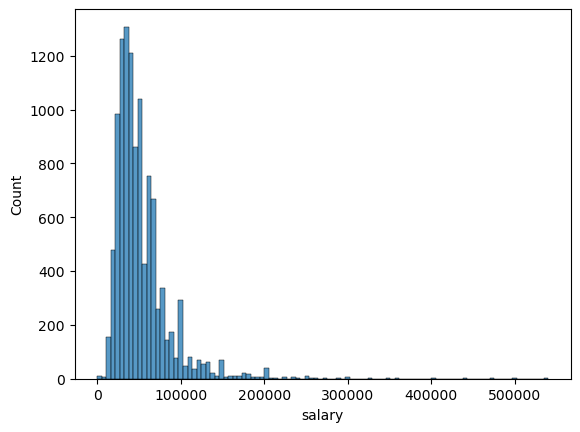

In [47]:
sns.histplot(df.salary, bins=100) # Distribition is close to normal, except for some outliers. But they can be real for top vacancies.

In [48]:
df.head()

,name,experience,description,key_skills,salary
0,Водитель-экспедитор,От 3 до 6 лет,"Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ ...",[],42500.0
1,Кладовщик-комплектовщик/оператор 1С,От 1 года до 3 лет,Обязанности: Списывание материалов в произво...,"['знание пк', 'работа в 1С', 'Работа в команде...",50000.0
3,Администратор магазина (ТЦ Spar),От 1 года до 3 лет,Крупная федеральная сеть магазинов мужской и ж...,[],36700.0
5,Менеджер-администратор,От 1 года до 3 лет,Международная сеть Школ скорочтения и развития...,"['Навыки межличностного общения', 'Грамотная р...",50000.0
6,Комплектовщик,Нет опыта,Мы прямой работодатель - компания «Форум-Авто»...,"['1С: Склад', 'Работа с оргтехникой', 'Приемка...",53500.0


In [51]:
df.reset_index(inplace = True, drop = True)

### 2.2. Creating a new text column which unites vacancy name, experience, key skills and description

In [78]:
df['text'] = df['name'] + df['experience'] + df['key_skills'] + df['description']

In [79]:
df.head()

,name,experience,description,key_skills,salary,text
0,Водитель-экспедитор,От 3 до 6 лет,"Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ ...",[],42500.0,Водитель-экспедиторОт 3 до 6 лет[]Водитель-экс...
1,Кладовщик-комплектовщик/оператор 1С,От 1 года до 3 лет,Обязанности: Списывание материалов в произво...,"['знание пк', 'работа в 1С', 'Работа в команде...",50000.0,Кладовщик-комплектовщик/оператор 1СОт 1 года д...
2,Администратор магазина (ТЦ Spar),От 1 года до 3 лет,Крупная федеральная сеть магазинов мужской и ж...,[],36700.0,Администратор магазина (ТЦ Spar)От 1 года до 3...
3,Менеджер-администратор,От 1 года до 3 лет,Международная сеть Школ скорочтения и развития...,"['Навыки межличностного общения', 'Грамотная р...",50000.0,Менеджер-администраторОт 1 года до 3 лет['Навы...
4,Комплектовщик,Нет опыта,Мы прямой работодатель - компания «Форум-Авто»...,"['1С: Склад', 'Работа с оргтехникой', 'Приемка...",53500.0,"КомплектовщикНет опыта['1С: Склад', 'Работа с ..."


### 2.3. Text preprocessing for further vectorization

In [80]:
morph = MorphAnalyzer()
stop_words = set(stopwords.words('russian'))

In [81]:
def preprocess_string(text):
    """
    Preprocesses the text string for further Word2Vec analysis.
    After the preprocessing the string contains words only and is lower-cased, tokenized, 
    without stop words and lemmatized.
    param text: string to preprocess.
    return: a preprocessed string.
    """
    text = re.sub(r'http\S+', '', text) # removing links
    
    text = re.sub('[^а-яА-ЯёЁa-zA-Z0-9]+', ' ', text) # saving words only
    
    text = word_tokenize(text.lower()) # tokenizing the text and turning to lower case
    
    text = [morph.normal_forms(token)[0] for token in text 
            if token not in stop_words and len(token) > 2]
    text = " ".join(text)
    
    return text

In [82]:
%%time
df['preprocessed_text'] = df['text'].apply(preprocess_string)

Wall time: 4min 5s


In [84]:
df = df.drop(['text'], axis=1)

In [85]:
df.head()

,name,experience,description,key_skills,salary,preprocessed_text
0,Водитель-экспедитор,От 3 до 6 лет,"Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ ...",[],42500.0,водитель экспедиторотый год водитель экспедито...
1,Кладовщик-комплектовщик/оператор 1С,От 1 года до 3 лет,Обязанности: Списывание материалов в произво...,"['знание пк', 'работа в 1С', 'Работа в команде...",50000.0,кладовщик комплектовщик оператор 1сотня год го...
2,Администратор магазина (ТЦ Spar),От 1 года до 3 лет,Крупная федеральная сеть магазинов мужской и ж...,[],36700.0,администратор магазин spar год год крупный фед...
3,Менеджер-администратор,От 1 года до 3 лет,Международная сеть Школ скорочтения и развития...,"['Навыки межличностного общения', 'Грамотная р...",50000.0,менеджер администраторотый год год навык межли...
4,Комплектовщик,Нет опыта,Мы прямой работодатель - компания «Форум-Авто»...,"['1С: Склад', 'Работа с оргтехникой', 'Приемка...",53500.0,комплектовщикнуть опыт склад работа оргтехника...


## 3. Splitting the data to train and text parts

In [142]:
X = df[['preprocessed_text']]
y = df['salary']

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=RANDOM_STATE)

## 4. Word2Vec

### 4.1. Model creation

In [146]:
w2v_model = Word2Vec(sentences=list(X_train.preprocessed_text.str.split()),
                     vector_size=100, window=5, workers=4)

In [147]:
w2v_vectors = w2v_model.wv

In [148]:
w2v_vectors['учитель'] # check that the model works

array([-0.14955054,  0.00945816, -0.03536884,  0.12875876, -0.17307527,
       -0.2692149 ,  0.0770104 ,  0.2716321 , -0.18534215, -0.00936239,
       -0.09816696, -0.4572544 , -0.01998047,  0.25256613, -0.023094  ,
       -0.13977861, -0.13116325, -0.39053723,  0.03947489, -0.51389813,
        0.13329609, -0.05993352,  0.06031588,  0.08058845, -0.15699501,
       -0.06588686, -0.04421274, -0.15666427, -0.05170143, -0.12460033,
        0.14047924, -0.04991068,  0.13267279, -0.23613992, -0.05740635,
        0.17647378,  0.2542776 ,  0.15262175, -0.01372419, -0.17474814,
        0.16109367, -0.29260394,  0.07559162,  0.14556085,  0.23750968,
        0.14870279, -0.43615264, -0.06820034,  0.05571977,  0.35019106,
        0.3303765 ,  0.02422653,  0.06773449,  0.16808869, -0.16379026,
        0.09390909,  0.25188679,  0.03237556, -0.11767698,  0.15884925,
        0.168076  ,  0.27109346, -0.19104835, -0.27841127, -0.23198807,
        0.12639017,  0.10926467,  0.02927609, -0.22596124,  0.26

In [149]:
w2v_vectors.vectors.shape

(7968, 100)

### 4.2. Embedding averaging

In [150]:
vectors_train = []
row = 0

for doc in tqdm(df.preprocessed_text.str.split()):
    res = np.zeros(100)
    cnt = 0
    for word in doc:
        if w2v_vectors.__contains__(word):
            res += w2v_model.wv[word]
            cnt += 1
    if cnt != 0:
        res /= cnt
    vectors_train.append(res)

vectors_train = np.array(vectors_train)

100%|██████████| 11090/11090 [00:05<00:00, 1891.94it/s]


In [151]:
vectors_test = []
row = 0

for doc in tqdm(df.preprocessed_text.str.split()):
    res = np.zeros(100)
    cnt = 0
    for word in doc:
        if w2v_vectors.__contains__(word):
            res += w2v_model.wv[word]
            cnt += 1
    if cnt != 0:
        res /= cnt
    vectors_test.append(res)

vectors_test = np.array(vectors_test)

100%|██████████| 11090/11090 [00:07<00:00, 1483.04it/s]


## 5. Salary prediction

### 5.1. Linear regression

In [175]:
linear = LinearRegression()

In [176]:
linear.fit(vectors_train, df.salary)

LinearRegression()

In [177]:
y_pred_lin = linear.predict(vectors_test)

In [178]:
predictions_lin = pd.DataFrame({'vacancy_name': df.name, 'salary': df.salary, 'salary_pred': y_pred_lin})

In [179]:
predictions_lin.head()

,vacancy_name,salary,salary_pred
0,Водитель-экспедитор,42500.0,49161.492085
1,Кладовщик-комплектовщик/оператор 1С,50000.0,49476.290101
2,Администратор магазина (ТЦ Spar),36700.0,52789.768432
3,Менеджер-администратор,50000.0,57080.031321
4,Комплектовщик,53500.0,59624.353858


In [183]:
predictions_lin.to_csv('pred_results/predicted_salaries_linear.csv', index=False)

<AxesSubplot:ylabel='Density'>

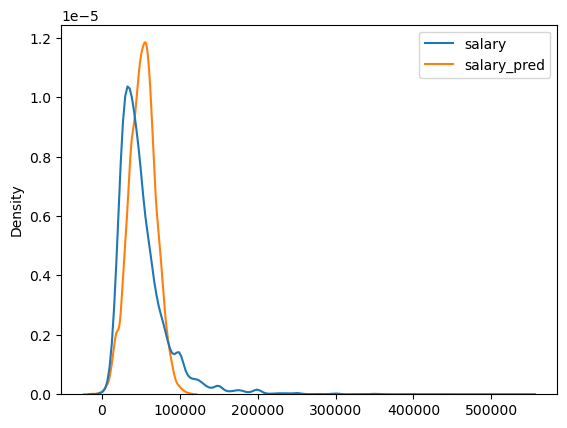

In [196]:
sns.kdeplot(data=predictions_lin)

### 5.2. Lasso

In [156]:
lasso = Lasso(max_iter=10_000)
lasso.fit(vectors_train, df.salary)

Lasso(max_iter=10000)

In [157]:
y_pred = lasso.predict(vectors_test)

In [169]:
predictions = pd.DataFrame({'vacancy_name': df.name, 'salary': df.salary, 'salary_pred': y_pred})

In [171]:
predictions.head()

,vacancy_name,salary,salary_pred
0,Водитель-экспедитор,42500.0,49814.409405
1,Кладовщик-комплектовщик/оператор 1С,50000.0,49860.484897
2,Администратор магазина (ТЦ Spar),36700.0,53247.946735
3,Менеджер-администратор,50000.0,56641.485579
4,Комплектовщик,53500.0,59241.427645


In [184]:
predictions.to_csv('pred_results/predicted_salaries_Lasso.csv', index=False)

<AxesSubplot:ylabel='Density'>

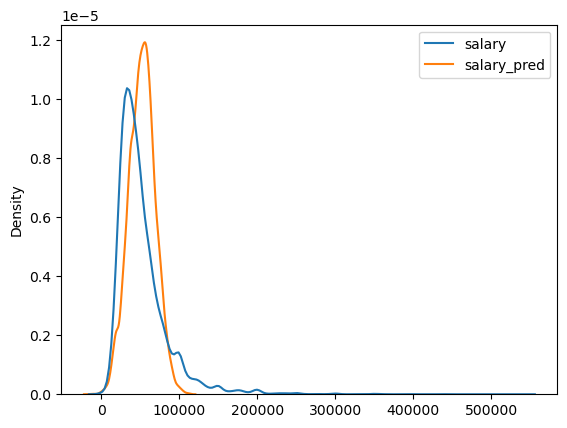

In [197]:
sns.kdeplot(data=predictions)